## Purpose of module

This module uses the technique described in 'Online short-term solar forecasting' by Bacher P, Madsen H & Nielsen HA (2009) to normalise the mean direct horizontal radiation by dividing by a clear sky model, created by smoothing the data in two dimensions; day of the year and hour of the day. 

## Import modules, load and transform data

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import pandas as pd
import patsy
import pytz
#import pyephem
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg

%matplotlib inline

In [2]:
PV_2017 = pd.read_csv('..//solar_data/PV_2017.csv',parse_dates=['date_time'],index_col='date_time')

# The timestamp in the input data is set to UTC but Pandas strips the time zone information when parsing.
# The following operation first creates 'time zone aware' timestamps, then localises it to Adelaide time.
PV_2017.index = PV_2017.index.tz_localize('UTC').tz_convert('Australia/Adelaide')

In [3]:
use_cols = ['mean_dir_horiz'] # Assuming this is the same as Global Horizontal Irradiance (GHI)
PV_2017 = PV_2017[use_cols]

In [4]:
PV_2017.head()

,mean_dir_horiz
date_time,
2017-01-01 00:00:00+10:30,0.0
2017-01-01 00:01:00+10:30,0.0
2017-01-01 00:02:00+10:30,0.0
2017-01-01 00:03:00+10:30,0.0
2017-01-01 00:04:00+10:30,0.0


In [5]:
# Confirm that the index is a time zone aware datetime object - return first and last objects
[PV_2017.iloc[0].name,PV_2017.iloc[-1].name]

[Timestamp('2017-01-01 00:00:00+1030', tz='Australia/Adelaide'),
 Timestamp('2017-12-31 23:59:00+1030', tz='Australia/Adelaide')]

Create new variables;

 * Time of day
 * Day of year

In [6]:
# Add time of day (in minutes from midnight at the start of each day)
PV_2017['time_of_day'] = PV_2017.index.map(lambda x: (
    x.combine(x.date(),x.time()) - x.combine(x.date(),dt.time(0,0))).seconds / 60 + 1)

In [7]:
# Add day of year beginning 1 January
first_day_of_year = dt.date(2017,1,1)
PV_2017['day_of_year'] = PV_2017.index.map(lambda x: (x.date() - first_day_of_year).days + 1)

In [23]:
# Add days since last winter solstice
winter_solstice = (6,21)

#PV_2017['days_since_winter_solstice'] = PV_2017.index.map(lambda x: (x.date() - winter_solstice).days + 1)

In [33]:
dt.date(dt.date.today().year,winter_solstice[0],winter_solstice[1])

datetime.date(2018, 6, 21)

In [55]:
def days_since_winter_solstice(qdate):
    current_years_solstice = dt.date(qdate.year,6,21)
    last_years_solstice = dt.date(qdate.year-1,6,21)
    if qdate < current_years_solstice:
        return (qdate - last_years_solstice).days + 1
    else:
        return (qdate - current_years_solstice).days + 1

PV_2017['days_since_winter_solstice'] = PV_2017.index.map(lambda x: days_since_winter_solstice(x.date()))

In [51]:
PV_2017.head()

,mean_dir_horiz,time_of_day,day_of_year,days_since_winter_solstice
date_time,,,,
2017-01-01 00:00:00+10:30,0.0,1.0,1,194
2017-01-01 00:01:00+10:30,0.0,2.0,1,194
2017-01-01 00:02:00+10:30,0.0,3.0,1,194
2017-01-01 00:03:00+10:30,0.0,4.0,1,194
2017-01-01 00:04:00+10:30,0.0,5.0,1,194


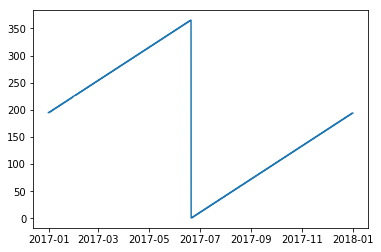

In [47]:
plt.plot(PV_2017.days_since_winter_solstice);

In [54]:
PV_2017.days_since_winter_solstice.min()

0

In [57]:
PV_2017.tail()

,mean_dir_horiz,time_of_day,day_of_year,days_since_winter_solstice
date_time,,,,
2017-12-31 23:55:00+10:30,0.0,1436.0,365,194
2017-12-31 23:56:00+10:30,0.0,1437.0,365,194
2017-12-31 23:57:00+10:30,0.0,1438.0,365,194
2017-12-31 23:58:00+10:30,0.0,1439.0,365,194
2017-12-31 23:59:00+10:30,0.0,1440.0,365,194


In [11]:
# There are some missing values in the data
PV_2017.mean_dir_horiz.isnull().values.any()

True

In [12]:
# Replace all missing values with zero
PV_2017 = PV_2017.fillna(0)

# Should this be the last observed point, or straight line between last observed and next observed? 

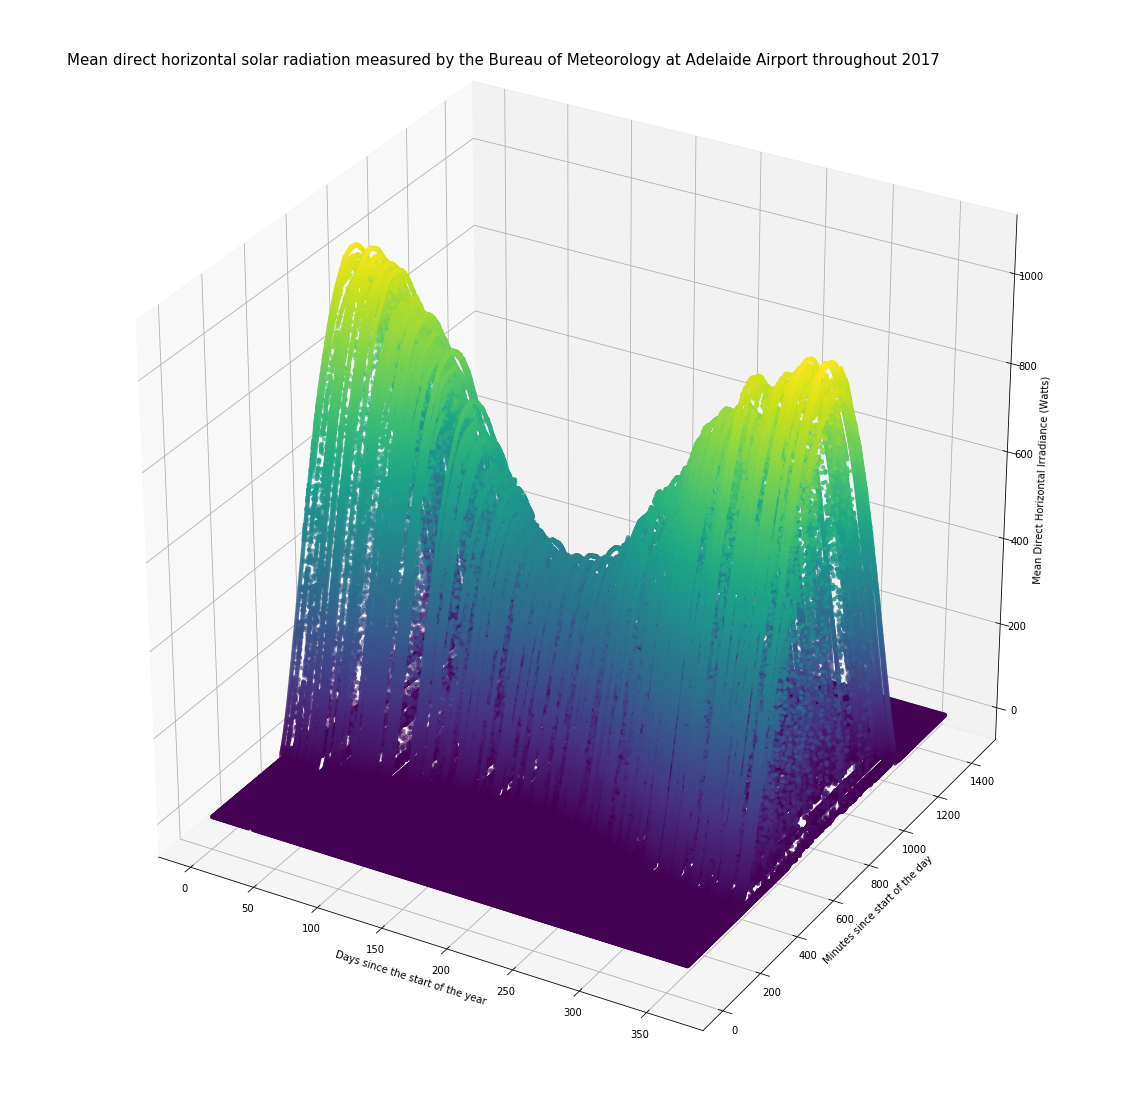

In [49]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_2017.day_of_year, PV_2017.time_of_day, PV_2017.mean_dir_horiz, 
                c=PV_2017.mean_dir_horiz, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since the start of the year')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

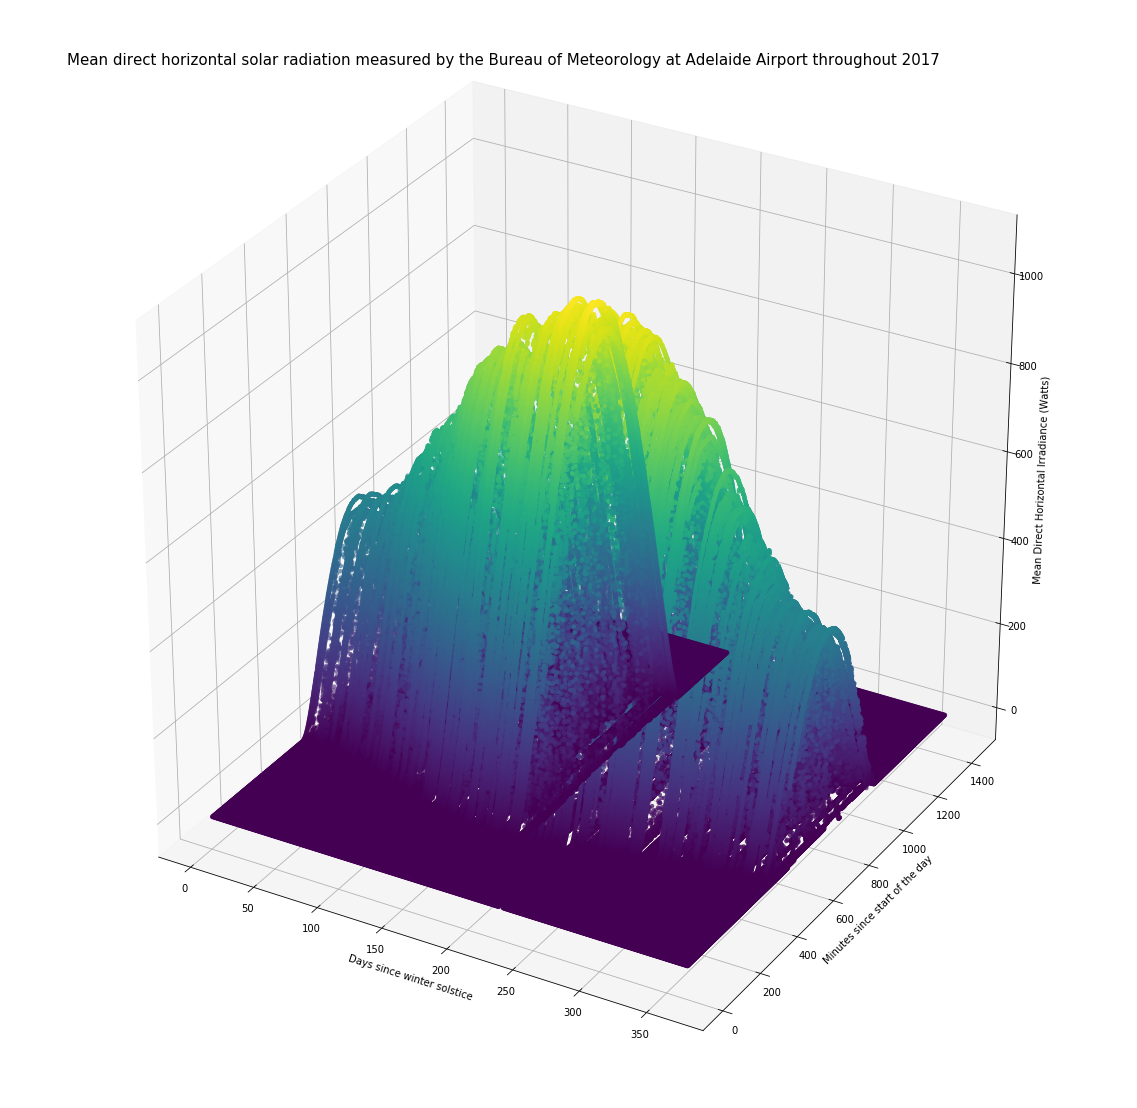

In [58]:
# Plot distribution of solar output by minute of the day and day of the year
fig = plt.figure(figsize=(20,20))
ax = plt.axes(projection='3d')
ax.scatter(PV_2017.days_since_winter_solstice, PV_2017.time_of_day, PV_2017.mean_dir_horiz, 
                c=PV_2017.mean_dir_horiz, linewidth=0.005)
ax.text2D(0.05, 0.95,
          'Mean direct horizontal solar radiation measured by the Bureau of Meteorology at Adelaide Airport throughout 2017',
          transform=ax.transAxes, fontsize=15)
ax.set_xlabel('Days since winter solstice')
ax.set_ylabel('Minutes since start of the day')
ax.set_zlabel('Mean Direct Horizontal Irradiance (Watts)')
plt.show()

## Calculate 'clear sky' prediction of solar radiation at each minute of each day

Appendix A of 'Online short-term solar power forecasting' by Bache, Madsen & Nielsen, published in Solar Energy, Volume 83 (2009), pp.1772-1783, describes a method for calculating estimated clear sky solar power $\hat{p}_{t}^{cs}$ given a solar power time series $p_t$, $t=1$,...,$N$, found as the $q$ quantile of ${ {f}_{P} }_{t}$, which is the probability distribution function of $P_t$.  This should be a smooth function intersecting the maximums of the actual values $p_i$ on the diagram above.

The problem is reduced to estimating $\hat{p}_{t}^{cs}$ as a local constant for each $(x_t,y_t)$, where $x$ is the days since the start of the year and $y$ is the number of minutes since the start of the day.  

The loss function $p(q,\epsilon_i$) is:

\begin{equation*}
\rho(q,\epsilon_i) =
\begin{cases}
    q\epsilon_i ,\quad \quad \quad \epsilon_i >= 0,  \\
    (1 - q)\epsilon_i ,\quad \epsilon_i < 0, \\
\end{cases}
\end{equation*}

where:

\begin{equation*}
\epsilon_i = p_i - \hat{p}_{t}^{cs}
\end{equation*}

The fitting is done by:

\begin{equation*}
\underset{\hat{p}_{t}^{cs}}{\operatorname{arg min}} = \sum_{i=1}^N k(x_t,y_t,x_i,y_i)\cdot \rho(q,\epsilon_i),
\end{equation*}

where:

\begin{equation*}
k(x_t,y_t,x_i,y_i) = \frac{w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}{\sum_{i=1}^N w(x_t,x_i,h_x)\cdot w(y_t,y_i,h_y)}
\end{equation*}

is the two-dimensional multiplicative kernel function which weights the observations locally to $(x_t,y_t)$, following Hastie & Tibshirani's 'Varying-Coefficient Models' published in the Journal of the Royal Statistical Society. Series B (Methodological), Vol. 55, No. 4 (1993), pp. 757-796.

In each dimension a Gaussian kernel (would a cosine kernel be better?) is used

\begin{equation*}
w(x_t,x_i,h_x) = f_{std}\left(\frac{\left|{x_t-x_i}\right|}{h_x}\right),
\end{equation*}

where $f_{std}$ is the standard normal probability density function. A similar kernel function is used in the $y$ dimension and the final two-dimensional kernel is found by multiplying the two kernels.

In the original paper, the technique used solar data from the northern hemisphere where 1 January is close to the winter solstice, making daily maximum $\hat{p}_{t}^{cs}$ over a year resemble a standard normal distribution. 

In our case, since the minimum solar radiation is in the middle of the year and the maximum at the extrema, it may be necessary to:

1. Transform the data to be the same shape by slicing the dataset on the winter solstice (21 June), then move the first portion of the time series (1 Jan 2017 to 21 Jun 2017) to follow 22 Jun 2017 to 31 Dec 2017.  (Could this be achieved by redefining the variable as days since last winter solstice?) or:

2. Flip the Gaussian kernel so that the tails approach the maximum and the 'peak' is at zero.  (Will this then still be a probability distribution function where the area under the curve equals 1? Does it matter for our purposes?)

3. Do the following:
    - Calculate the length of the day (or) night for each day of the year.
    - Calculate the mean and standard deviation for the day length
    - Stan
    



In [14]:
help(QuantReg)

Help on class QuantReg in module statsmodels.regression.quantile_regression:

class QuantReg(statsmodels.regression.linear_model.RegressionModel)
 |  Quantile Regression
 |  
 |  Estimate a quantile regression model using iterative reweighted least
 |  squares.
 |  
 |  Parameters
 |  ----------
 |  endog : array or dataframe
 |      endogenous/response variable
 |  exog : array or dataframe
 |      exogenous/explanatory variable(s)
 |  
 |  Notes
 |  -----
 |  The Least Absolute Deviation (LAD) estimator is a special case where
 |  quantile is set to 0.5 (q argument of the fit method).
 |  
 |  The asymptotic covariance matrix is estimated following the procedure in
 |  Greene (2008, p.407-408), using either the logistic or gaussian kernels
 |  (kernel argument of the fit method).
 |  
 |  References
 |  ----------
 |  General:
 |  
 |  * Birkes, D. and Y. Dodge(1993). Alternative Methods of Regression, John Wiley and Sons.
 |  * Green,W. H. (2008). Econometric Analysis. Sixth Edition

In [15]:
help(smf.ols)

Help on method from_formula in module statsmodels.base.model:

from_formula(formula, data, subset=None, drop_cols=None, *args, **kwargs) method of builtins.type instance
    Create a Model from a formula and dataframe.
    
    Parameters
    ----------
    formula : str or generic Formula object
        The formula specifying the model
    data : array-like
        The data for the model. See Notes.
    subset : array-like
        An array-like object of booleans, integers, or index values that
        indicate the subset of df to use in the model. Assumes df is a
        `pandas.DataFrame`
    drop_cols : array-like
        Columns to drop from the design matrix.  Cannot be used to
        drop terms involving categoricals.
    args : extra arguments
        These are passed to the model
    kwargs : extra keyword arguments
        These are passed to the model with one exception. The
        ``eval_env`` keyword is passed to patsy. It can be either a
        :class:`patsy:patsy.Eval

Build quantile regression model predicting GHI from the number of minutes after the start of the day - based on __[the examples in the documentation](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)__

In [59]:
quantiles = np.arange(0.6,1,.025)

def fit_model(q):
    mod = smf.quantreg('mean_dir_horiz ~ time_of_day + days_since_winter_solstice', PV_2017)
    res = mod.fit(q=q, kernel='gau')
    return [q, res.params['Intercept'], res.params['time_of_day']] + \
           res.conf_int().loc['time_of_day'].tolist()

models = [fit_model(y) for y in quantiles]
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])


In [60]:
models = pd.DataFrame(models, columns=['q','a','b','lb','ub'])
models

,q,a,b,lb,ub
0,0.600,-0.003107,0.000475,0.000424,0.000527
1,0.625,-0.014505,0.001267,0.001218,0.001317
2,0.650,-0.082762,0.004373,0.004315,0.004431
3,0.675,-0.385086,0.016638,0.016520,0.016755
4,0.700,-1.487304,0.045520,0.045258,0.045783
5,0.725,-4.798317,0.089563,0.088778,0.090349
6,0.750,-7.865609,0.141415,0.139824,0.143007
7,0.775,-7.951709,0.205463,0.203027,0.207899
8,0.800,-1.196383,0.276510,0.273161,0.279859
9,0.825,62.105547,0.297706,0.293731,0.301682


In [61]:
mod = smf.quantreg('mean_dir_horiz ~ time_of_day + days_since_winter_solstice', PV_2017)

In [62]:
res = mod.fit(q=0.85, kernel='gau')

In [63]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:         mean_dir_horiz   Pseudo R-squared:             0.008409
Model:                       QuantReg   Bandwidth:                       12.06
Method:                 Least Squares   Sparsity:                        2761.
Date:                Mon, 20 Aug 2018   No. Observations:               521280
Time:                        15:02:36   Df Residuals:                   521277
                                        Df Model:                            2
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    125.1170      2.655     47.126      0.000     119.913     130.321
time_of_day                    0.3264      0.002    193.719      0.000       0.323       0.330
days_since_winter_solstice     0.1920      0.010     18.422      0.000       0.172       0.212
==============================================================================================

The condition number is large, 2.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This does not appear to be fitting a normal distribution to the data.

In [65]:
from scipy.optimize import curve_fit

In [ ]:
curve_fit.

The headings for the output parameters are based on a linear regression. What do these represent and how can they be translated back into a normal distribution?